In [1]:
%matplotlib inline

import time
import tarfile
import re
import io

import numpy
import pandas
import matplotlib.pyplot as plt

import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn import metrics

import librosa
import librosa.display

In [2]:

def load_dataset(featurespath, labelpath=None, name=None, datadir='data/mels64-median3-fmin0-fmax20050-minmax/'):    
    if name is None:
        name=featurespath.split('_')[0]
    features = pandas.read_csv(datadir+featurespath)
    features['dataset'] = name 
    #regex = re.compile(r'wav\/(.*).wav')
    #itemid = features.filename.astype('str').str.replace(pat=regex, repl=lambda m: m.group(1), regex=True)
    itemid = features.filename.str.replace('.wav', '', regex=False).str.replace('wav/', '')
    itemid = itemid.str.replace('PolandNFC_test_', '')
    itemid = itemid.str.replace('wabrlrb10k_test_', '')
    itemid = itemid.str.replace('chern_', '')
    features.index = itemid

    data = features.copy()
    
    if labelpath:
        labels = pandas.read_csv(datadir+labelpath, index_col='itemid')
        labels.index = labels.index.astype('str')
        data['hasbird'] = labels.hasbird.astype('bool')

    return data


In [41]:
train_ff1010 = load_dataset('ff1010bird_wav.melmax.csv', 'ff1010bird.labels.csv')
train_warblr = load_dataset('warblrb10k_public_wav.melmax.csv', 'warblrb10k.labels.csv')
train_dcase = load_dataset('birdvox_2k_wav.melmax.csv', 'birdvox.labels.csv')
predict_poland = load_dataset('PolandNFC_test_wav.melmax.csv')
predict_warblr = load_dataset('wabrlrb10k_test_wav.melmax.csv')
predict_chern = load_dataset('chern_wav.melmax.csv')

train_dcase.dropna(axis=0, inplace=True)

dataset = pandas.concat([train_ff1010, train_warblr, train_dcase], sort=False)
compete = pandas.concat([predict_warblr, predict_chern, predict_poland], sort=False)
alldata = pandas.concat([compete, dataset], sort=False)

print('training', dataset.shape)
print('competition', compete.shape)

training (18409, 67)
competition (12620, 66)


# Data analysis

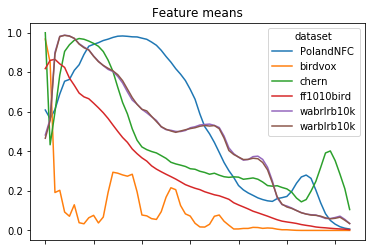

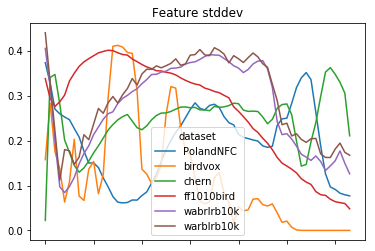

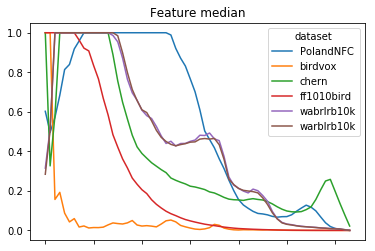

In [42]:
alldata.groupby('dataset').mean().T.plot(title='Feature means')
alldata.groupby('dataset').std().T.plot(title='Feature stddev')
alldata.groupby('dataset').median().T.plot(title='Feature median')

Large difference in feature distributions. 

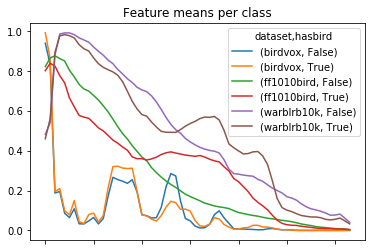

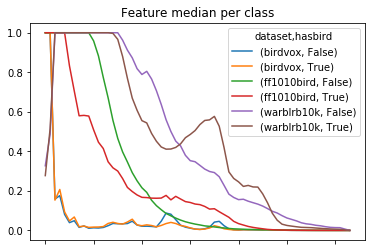

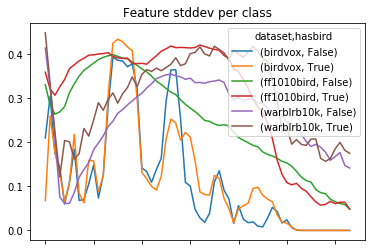

In [43]:
alldata.groupby(['dataset', 'hasbird']).mean().T.plot(title='Feature means per class')
alldata.groupby(['dataset', 'hasbird']).median().T.plot(title='Feature median per class')
alldata.groupby(['dataset', 'hasbird']).std().T.plot(title='Feature stddev per class')

In [40]:
label_columns = ['hasbird']
ignore_columns = ['filename', 'dataset']
feature_columns = list(set(dataset.columns) - set(label_columns) - set(ignore_columns))
X = dataset[feature_columns]
Y = dataset[label_columns[0]]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=1)
print('dataset', X.shape, Y.shape, numpy.mean(Y))

rf = make_pipeline(
    RandomForestClassifier(n_estimators=100, random_state=1),
)

start = time.time()
rf.fit(X_train, Y_train)
end = time.time()
print('Train time', end-start)

train = model_selection.cross_val_score(rf, X_train, Y_train, scoring='roc_auc', cv=5)
print('Train score: {:.4f} {:.4f} ||'.format(numpy.mean(train), numpy.std(train)), train)

test = model_selection.cross_val_score(rf, X_test, Y_test, scoring='roc_auc', cv=5)
print('Test score: {:.4f} {:.4f} ||'.format(numpy.mean(test), numpy.std(test)), test)

# test
Y_pred = rf.predict(X_test)
recall = metrics.recall_score(Y_test, Y_pred)
print('recall', recall)

metrics.confusion_matrix(Y_test, Y_pred)

dataset (18409, 64) (18409,) 0.5086042065009561


ValueError: Unknown label type: 'unknown'

In [9]:
cf = metrics.confusion_matrix(Y_test, Y_pred)
numpy.round(cf / cf.sum(axis=0), 4)*100

array([[78.34, 21.01],
       [21.66, 78.99]])

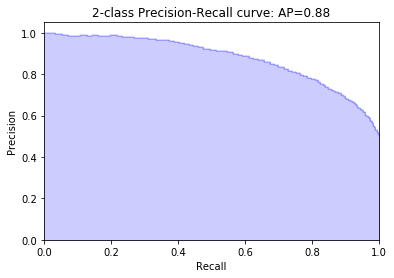

In [10]:
plot_precision_recall(Y_test, rf.predict_proba(X_test)[:,1])

order [57 56 47 39  3 37 60 24 23 29 40 14 13  8  4 21 50 44 55 45 31 15 30 32
 17 61 42 34 43 35  0 58 54 48 20 11 41 18 22 12  1 59 53 33 46 51 28  6
  2 25 27 62 10 38 49 52 63 16 36  9  7  5 26 19]


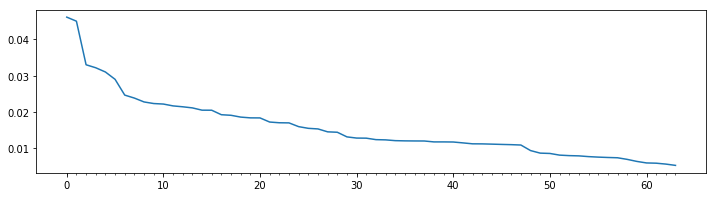

In [11]:
importance = rf.steps[0][1].feature_importances_
order = numpy.argsort(importance)[::-1]
print('order', order)
f = plt.figure(figsize=(12,3))
p = f.add_subplot(111)
x = list(range(len(importance)))
p.plot(x, importance[order])
tt = [str(t) for t in order]
p.set_xticks(x, tt)
None

In [95]:
#best_features = list(order[:24])
#best_features

In [12]:
X_compete = compete[feature_columns]
#X_compete = X_compete.iloc[:,numpy.array(best_features)]
df = pandas.DataFrame({
    'item': X_compete.index, 
    'prediction': rf.predict(X_compete).astype('int'),
})

# check all items correctly named
example = pandas.read_csv('example.csv', header=None)
diff = set(example[0]).symmetric_difference(df.item)
assert diff == set()

df.to_csv('prediction.csv', index=False, header=False)